#0.0 IMPORTS

In [1]:
pip install boruta

In [2]:
pip install inflection

In [3]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import xgboost             as xgb

import warnings
import json
import math
import inflection
import pickle
import random

from sklearn                   import metrics
from sklearn.preprocessing     import LabelEncoder,RobustScaler,MinMaxScaler
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_absolute_error,mean_squared_error
from sklearn.linear_model      import LinearRegression,Lasso
from boruta                    import BorutaPy
from IPython.display           import Image

##0.1 Helper Functions

###0.1.1 Métricas

In [4]:
def ml_error(model_name,y,yhat):

  mae=mean_absolute_error(y,yhat)
  mape=mean_absolute_percentage_error(y,yhat)
  rmse=np.sqrt(mean_squared_error(y,yhat))
  accuracy=metrics.r2_score(y,yhat).round(2)*100

  return pd.DataFrame({'Model Name':model_name,
                       'MAE':mae,
                       'MAPE':mape,
                       'RMSE':rmse ,
                       'ACCURACY':accuracy

                       },index=[0])
  

def mean_absolute_percentage_error(y,yhat):
  return np.mean(np.abs((y-yhat)/y))


def mean_absolute_error(y,yhat):
  return np.mean((y-yhat)/y)



def cross_validation(x_training,kfold,model_name,model,verbose=False):

  mae_list=[]
  mape_list=[]
  rmse_list=[]
  accuracy_list=[]

  for K in range(1,kfold+1): 
        
    #beginning and end of validation
    validation_start=K*20
    validation_end=validation_start+20

    #Filtering in dataset
    aux=x_training[(x_training['MotorId']>=validation_start) & (x_training['MotorId']<=validation_end)]
 
    training=x_training.drop(aux.index,axis=0)
    validation=x_training[(x_training['MotorId']>=validation_start) & (x_training['MotorId']<=validation_end)]

    #Training and validation dataset

    #Training
    xtraining=training.drop(['Resposta'],axis=1)
    ytraining=training['Resposta']

    #Validation
    xvalidation=validation.drop(['Resposta'],axis=1)
    yvalidation=validation['Resposta']

    #model
    m=model.fit(xtraining,ytraining)

    #prediction
    yhat=m.predict(xvalidation)

    #performance
    m_results=ml_error(model_name,np.expm1(yvalidation),np.expm1(yhat))
    
    #store performance of each KFold iteration
    mae_list.append(m_results['MAE'])
    mape_list.append(m_results['MAPE'])
    rmse_list.append(m_results['RMSE'])
    accuracy_list.append(m_results['ACCURACY'])

  return pd.DataFrame({ 'Model name': model_name,'MAE CV':np.round(np.mean(mae_list),2).astype(str)+' +/- '+ np.round(np.std(mae_list),2).astype(str),
                        'MAPE CV':    np.round(np.mean(mape_list),2).astype(str)                   +' +/- '+ np.round(np.std(mape_list),2).astype(str),
                        'RMSE CV':    np.round(np.mean(rmse_list),2).astype(str)                   +' +/- '+ np.round(np.std(rmse_list),2).astype(str),
                        'ACURACY CV': np.round(np.mean(accuracy_list),2).astype(str)               +' +/- '+ np.round(np.std(accuracy_list),2).astype(str)
                        },index=[0])
  
  

def estatistica_descritiva(data):

  #selecao
  num_attributes=data.select_dtypes(include=['int64','float64'])

  #Central tendency=mean,median
  ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
  ct2=pd.DataFrame(num_attributes.apply(np.median)).T

  # Dispersion=std,min,max,range,skew,kurtosis
  d1=pd.DataFrame(num_attributes.apply(np.std)).T
  d2=pd.DataFrame(num_attributes.apply(min)).T
  d3=pd.DataFrame(num_attributes.apply(max)).T
  d4=pd.DataFrame(num_attributes.apply(lambda x:x.mean()-x.min())).T
  d5=pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
  d6=pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

  #Concatenate
  aux=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()  
  aux.columns=(['attributes','min','max','range','mean','median','std','skew','kurtosis']) 

  return aux

###0.1.2 Gráficos

In [5]:
def grafico_de_correlacao(x,y,data):

  #regplot
  plt.subplot(1,3,1)
  ax=sns.regplot(x=x,y=y,data=data)
  ax.figure.set_size_inches(18,4)

  #boxplot
  plt.subplot(1,3,2)
  ax=sns.boxplot(data=data[y])

  #heatmap
  plt.subplot(1,3,3)
  ax=sns.heatmap(data[[x,y]].corr(method='pearson'),annot=True);
  
  return ax

###0.1.3 Boruta

In [6]:
def boruta (x_train,y_train):
  
  #Training and test dataset for Boruta
  X_train_boruta = x_train.values
  Y_train_boruta = y_train.values.ravel()

  #Define RandomForestRegressor
  rf=RandomForestRegressor(n_jobs=-1)

  #Define Boruta
  boruta=BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(X_train_boruta,Y_train_boruta)  
  
  return boruta
  

#best_features
def best_features(boruta,x_train):

  cols_selected=boruta.support_.tolist()

  #best features
  x_train_fs=x_train
  cols_selected_boruta=x_train_fs.iloc[:,cols_selected].columns.to_list()

  #not selected boruta
  cols_not_selected_boruta=list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))

  return cols_selected_boruta

###0.1.4 Outliers

In [7]:
def calcula_limite_superior_e_inferior(data):

  q1=data.quantile(0.25)
  q3=data.quantile(0.75)
  
  iiq=q3-q1

  limite_inferior=q1-1.5*iiq
  limite_superior=q3+1.5*iiq
  
  return [limite_superior,limite_inferior]


def retira_outliers(data):

  si=calcula_limite_superior_e_inferior(data)

  return (data<si[0]) & (data>si[1])

###0.1.5 Rescaling

In [8]:
def rescaling(data,selecao):

  for i in range(0,len(selecao.columns)):

    #ferramenta
    mms=MinMaxScaler()

    coluna=selecao.columns[i]
    selecao[coluna]=mms.fit_transform(selecao[[coluna]].values)
    data[coluna]=selecao[coluna]

  return data

##0.2 Loading Data

In [9]:
#renomeando colunas
columns=['MotorId','Ciclos','Config1','Config2',
         'Config3', 'Sensor1','Sensor2','Sensor3','Sensor4',
         'Sensor5','Sensor6','Sensor7','Sensor8','Sensor9','Sensor10',
         'Sensor11','Sensor12','Sensor13','Sensor14','Sensor15','Sensor16',
         'Sensor17','Sensor18','Sensor19','Sensor20','Sensor21']

#rul_raw
rul_raw=pd.read_table('/content/RUL_FD001.txt',sep='\s+',names=['RulEsperado'])

#test_raw
test_raw=pd.read_table('/content/test_FD001.txt',sep='\s+',names=columns)

#train_raw
train_raw=pd.read_table('/content/train_FD001.txt',sep='\s+',names=columns)

# 1.0 PASSO 1 - DESCRIPTION OF THE DATA

In [10]:
df1=train_raw.copy()

##1.1 Data Dimensions

In [11]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 20631
Número de colunas: 26


##1.2 Data Types

In [12]:
df1.dtypes

MotorId       int64
Ciclos        int64
Config1     float64
Config2     float64
Config3     float64
Sensor1     float64
Sensor2     float64
Sensor3     float64
Sensor4     float64
Sensor5     float64
Sensor6     float64
Sensor7     float64
Sensor8     float64
Sensor9     float64
Sensor10    float64
Sensor11    float64
Sensor12    float64
Sensor13    float64
Sensor14    float64
Sensor15    float64
Sensor16    float64
Sensor17      int64
Sensor18      int64
Sensor19    float64
Sensor20    float64
Sensor21    float64
dtype: object

##1.3 Check NA

In [13]:
df1.isna().sum()

MotorId     0
Ciclos      0
Config1     0
Config2     0
Config3     0
Sensor1     0
Sensor2     0
Sensor3     0
Sensor4     0
Sensor5     0
Sensor6     0
Sensor7     0
Sensor8     0
Sensor9     0
Sensor10    0
Sensor11    0
Sensor12    0
Sensor13    0
Sensor14    0
Sensor15    0
Sensor16    0
Sensor17    0
Sensor18    0
Sensor19    0
Sensor20    0
Sensor21    0
dtype: int64

##1.4 Descriptive Statistical

In [14]:
num_attributes=df1.select_dtypes(include=['int64','float64'])
cat_attributes=df1.select_dtypes(include='object')

print('Número de atributos númericos:   {}'.format(num_attributes.shape[1]))
print('Número de atributos categóricos: {}'.format(cat_attributes.shape[1]))

Número de atributos númericos:   26
Número de atributos categóricos: 0


###1.5.1 Numerical Attributes

In [15]:
estatistica_descritiva(df1)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,MotorId,1.0000,100.0000,5.050657e+01,51.506568,52.0000,2.922692e+01,-0.067815,-1.219824
1,Ciclos,1.0000,362.0000,1.078079e+02,108.807862,104.0000,6.887932e+01,0.499904,-0.218539
2,Config1,-0.0087,0.0087,8.691130e-03,-0.000009,0.0000,2.187260e-03,-0.024766,-0.009132
3,Config2,-0.0006,0.0006,6.023508e-04,0.000002,0.0000,2.930550e-04,0.009085,-1.130447
4,Config3,100.0000,100.0000,0.000000e+00,100.000000,100.0000,0.000000e+00,0.000000,0.000000
5,Sensor1,518.6700,518.6700,-6.536993e-11,518.670000,518.6700,6.536993e-11,0.000000,0.000000
6,Sensor2,641.2100,644.5300,1.470934e+00,642.680934,642.6400,5.000412e-01,0.316526,-0.112043
7,Sensor3,1571.0400,1616.9100,1.948312e+01,1590.523119,1590.1000,6.131001e+00,0.308946,0.007762
8,Sensor4,1382.2500,1441.4900,2.668378e+01,1408.933782,1408.0400,9.000387e+00,0.443194,-0.163681
9,Sensor5,14.6200,14.6200,-3.394618e-12,14.620000,14.6200,3.394618e-12,0.000000,0.000000


#2.0 PASSO 2 - FEATURE ENGINEERING

In [16]:
df2=df1.copy()

##2.1 Feature Engineering

In [17]:
#ultimo_ciclo
ultimo_ciclo=[]
for i in range(1,101):
  ultimo_ciclo.append(df2[df2['MotorId']==i]['Ciclos'].max())

ultimo_ciclo=pd.DataFrame(data=ultimo_ciclo,columns=['UltimoCiclo'])

#merge rul_raw,ultimo_ciclo e motor_id
aux=pd.merge(rul_raw,ultimo_ciclo,left_index=True,right_index=True)

motor_id=[]
for i in range(1,101):
  motor_id.append(i)
motor_id=pd.DataFrame(data=motor_id,columns=['MotorId'])

aux=pd.merge(aux,motor_id,left_index=True,right_index=True)
df2=pd.merge(df2,aux,on='MotorId')

#CiclosAteFalhar
df2['CiclosAteFalhar']=df2['UltimoCiclo']+df2['RulEsperado']

#S4+S11
df2['S4+S11']=(df2['Sensor4']+df2['Sensor11'])/2

#S12+S7
df2['S12+S7']=(df2['Sensor12']+df2['Sensor7'])/2

#S12+S11
df2['S12+S11']=(df2['Sensor12']+df2['Sensor11'])/2

#S11+S7
df2['S11+S7']=(df2['Sensor4']+df2['Sensor11'])/2

#Resposta
df2['Resposta']=df2['CiclosAteFalhar']-df2['Ciclos']

#3.0. PASSO 3 - VARIABLES FILTERING

In [18]:
#copia do dataframe
df3=df2.copy()

##3.1. Line Filtering

In [19]:
lista=['Sensor2','Sensor3','Sensor4','Sensor7',
       'Sensor8','Sensor9','Sensor11','Sensor12',
       'Sensor13','Sensor14','Sensor15','Sensor20','Sensor21']

for i in range(0,len(lista)):
  df3=df3[retira_outliers(df3[lista[i]])]

##3.2. Column selection

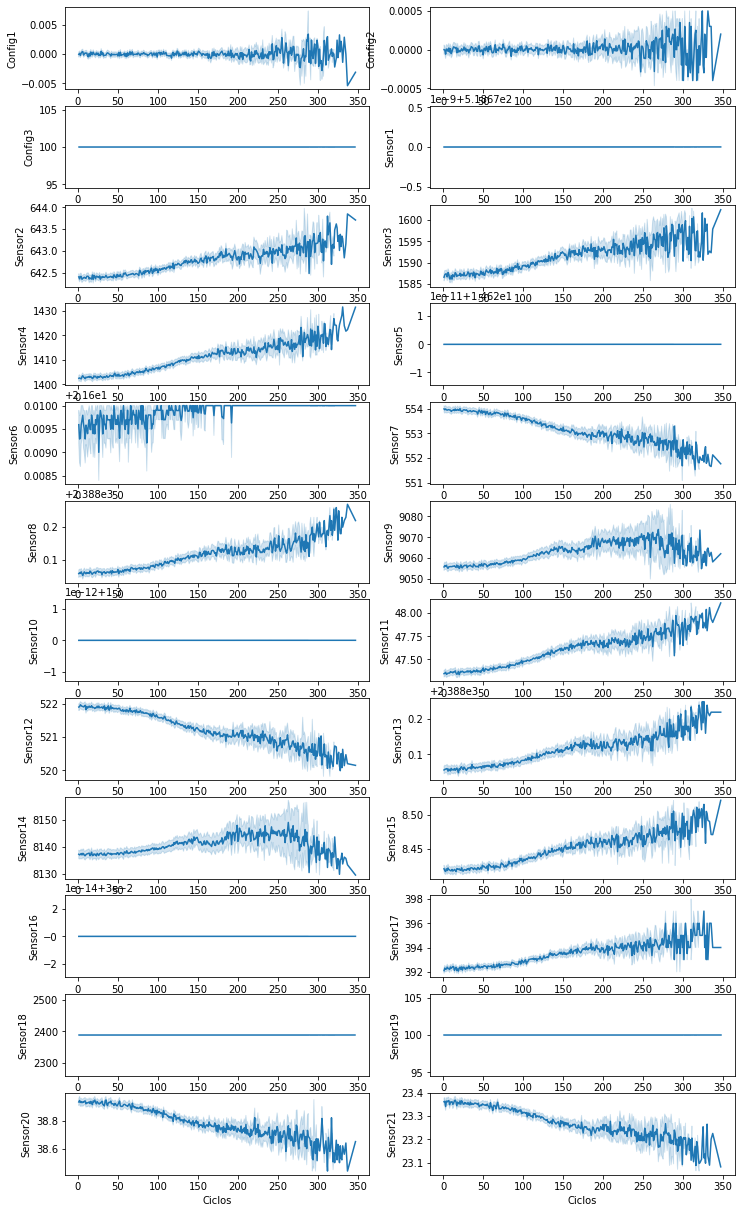

In [20]:
lista=['Config1','Config2','Config3','Sensor1','Sensor2','Sensor3',
       'Sensor4','Sensor5','Sensor6','Sensor7','Sensor8','Sensor9','Sensor10','Sensor11',
       'Sensor12','Sensor13','Sensor14','Sensor15','Sensor16', 'Sensor17','Sensor18',
       'Sensor19','Sensor20','Sensor21']

for i in range(0,len(lista)):
  
  plt.subplot(20,2,i+1)
  ax=sns.lineplot(x='Ciclos', y=lista[i],data=df3)
  ax.figure.set_size_inches(12,36)

In [21]:
delete=['Config3','Sensor1','Sensor5','Sensor10','Sensor16','Sensor18','Sensor19','RulEsperado']
df3=df3.drop(delete,axis=1)

#4.0. PASSO 4 - EXPLORATORY DATA ANALYSIS

In [22]:
#Copia do dataframe
df4=df3.copy()

## 4.1 Univariate Analysis

###4.1.1. Response Variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


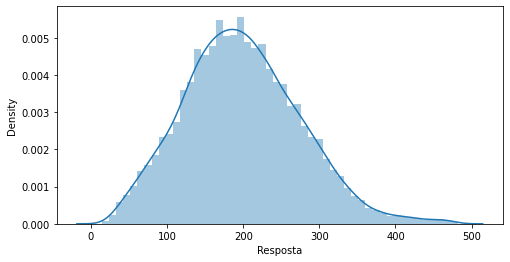

In [23]:
ax=sns.distplot(df4['Resposta'])
ax.figure.set_size_inches(8,4)

###4.1.2. Numerical Variable

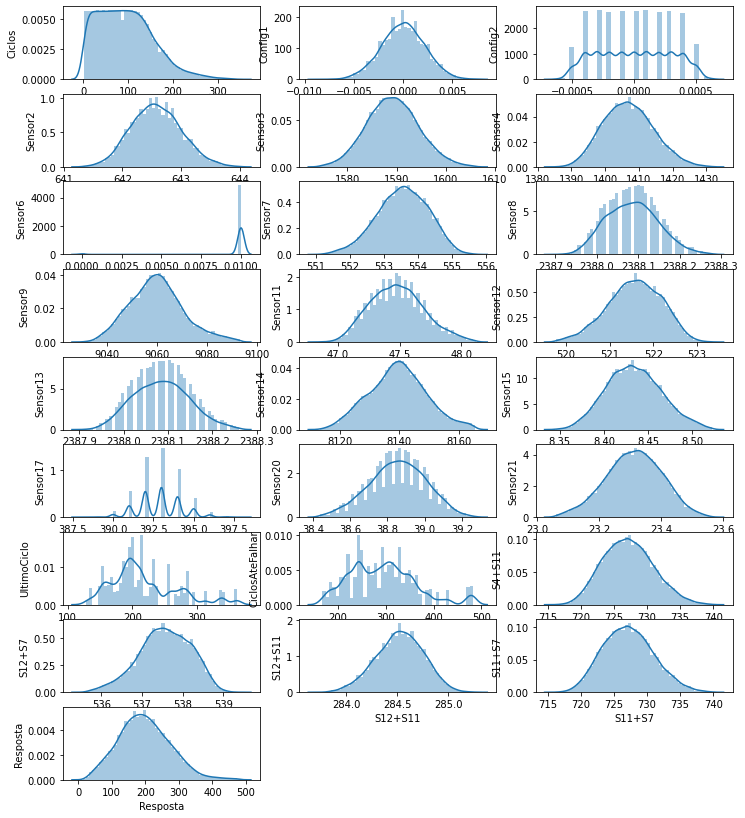

In [24]:
warnings.filterwarnings('ignore')

lista=df3.columns.drop(['MotorId'])

for i in range(0,len(lista)):

  plt.subplot(len(lista),3,i+1)
  ax.figure.set_size_inches(12,40)
  ax=sns.distplot(df3[lista[i]])  
  ax.set_ylabel(lista[i])

## 4.2 Bivariate Analysis

### Sensor2

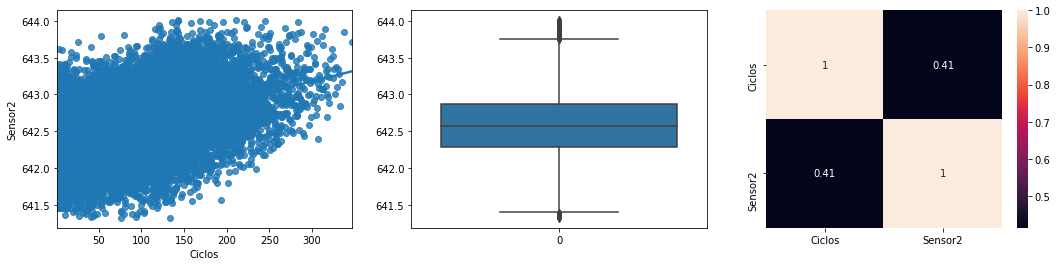

In [25]:
grafico_de_correlacao('Ciclos','Sensor2',df4)

### Sensor3

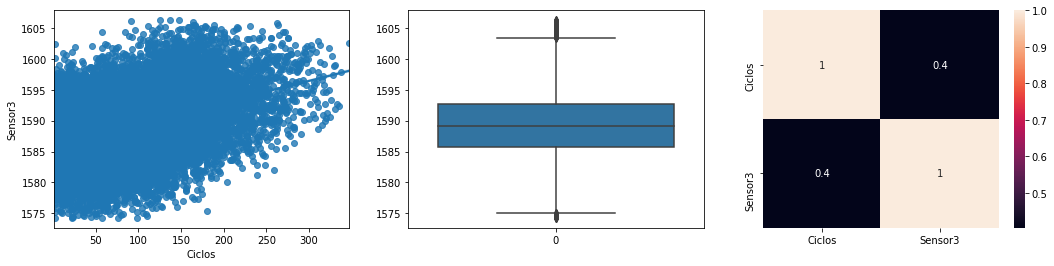

In [26]:
grafico_de_correlacao('Ciclos','Sensor3',df4)

### Sensor4

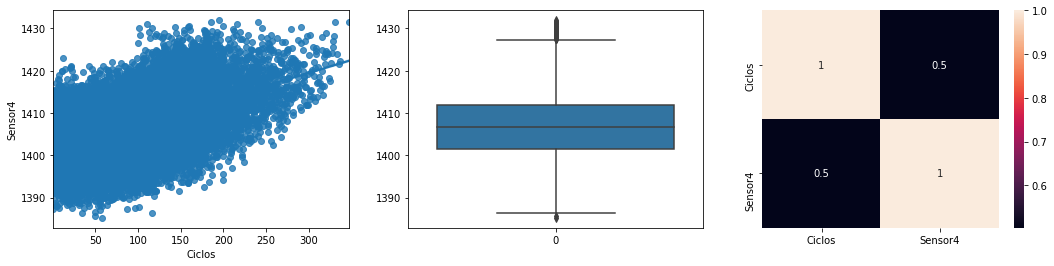

In [27]:
grafico_de_correlacao('Ciclos','Sensor4',df4)

### Sensor7

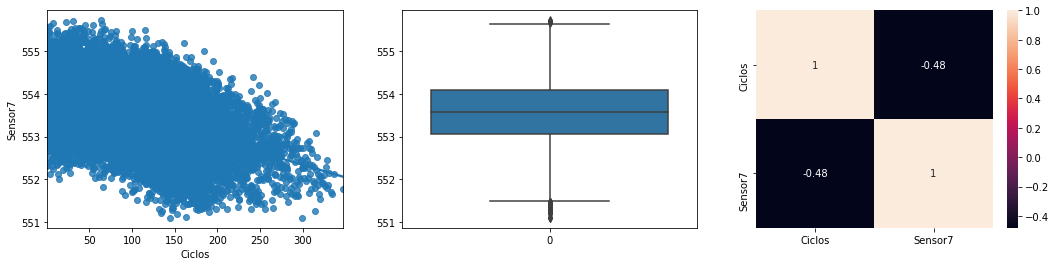

In [28]:
grafico_de_correlacao('Ciclos','Sensor7',df4)

### Sensor8

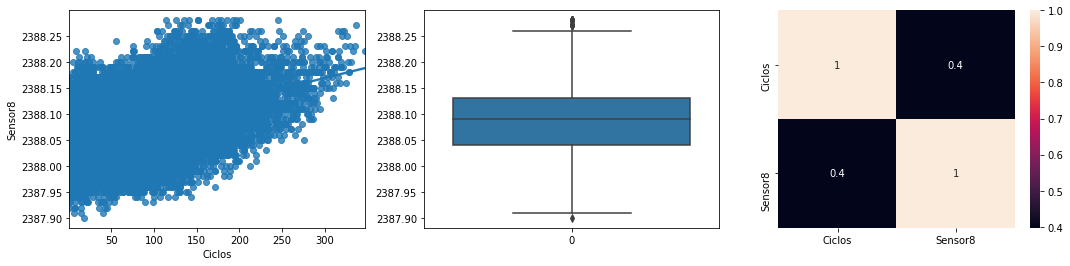

In [29]:
grafico_de_correlacao('Ciclos','Sensor8',df4)

### Sensor11

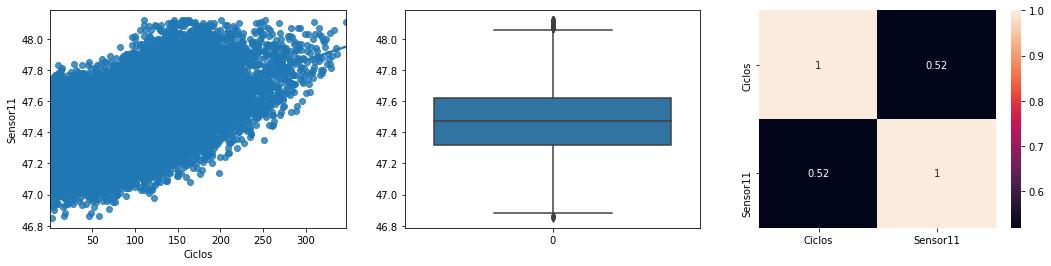

In [30]:
grafico_de_correlacao('Ciclos','Sensor11',df4)

### Sensor12

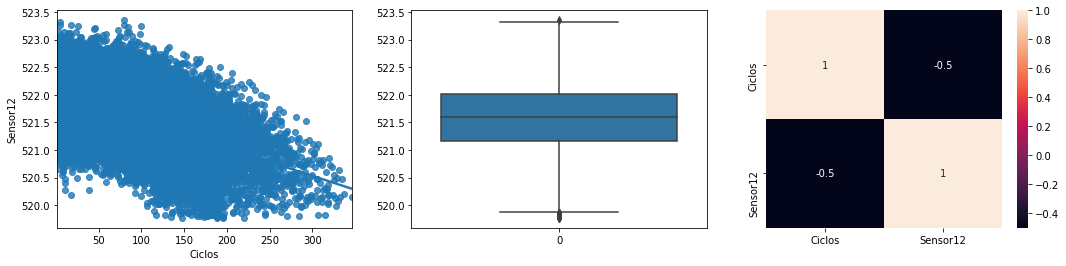

In [31]:
grafico_de_correlacao('Ciclos','Sensor12',df4)

### Sensor13

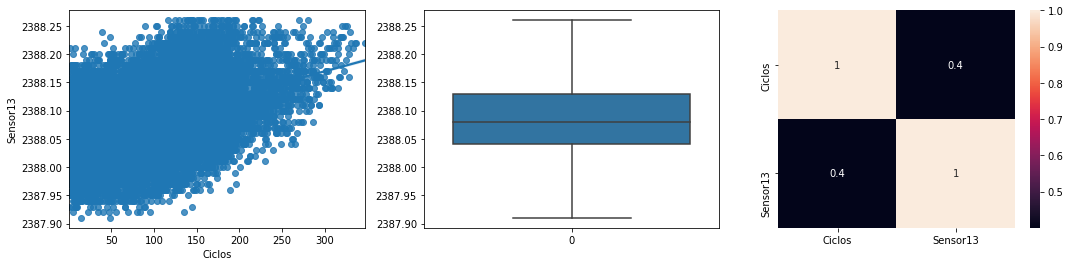

In [32]:
grafico_de_correlacao('Ciclos','Sensor13',df4)

### Sensor14

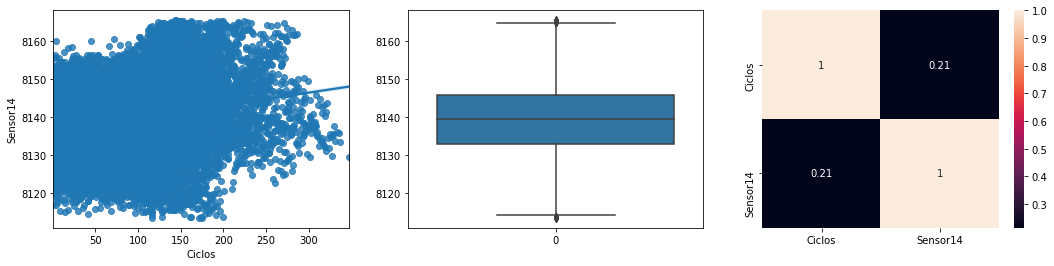

In [33]:
grafico_de_correlacao('Ciclos','Sensor14',df4)

### Sensor15

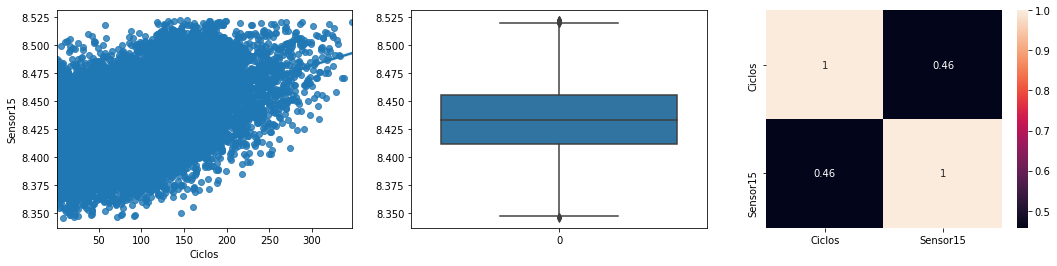

In [34]:
grafico_de_correlacao('Ciclos','Sensor15',df4)

### Sensor20

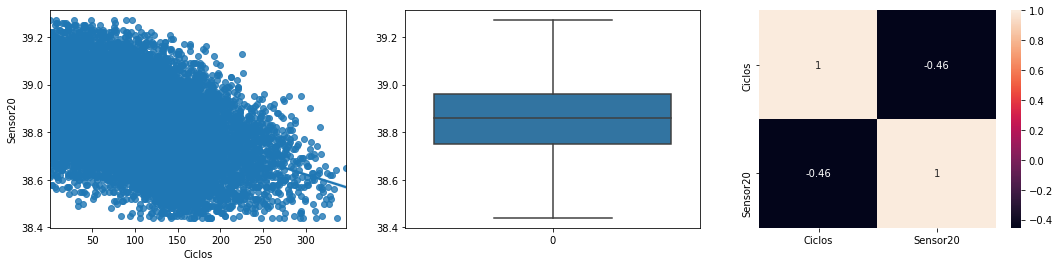

In [35]:
grafico_de_correlacao('Ciclos','Sensor20',df4)

### Sensor21

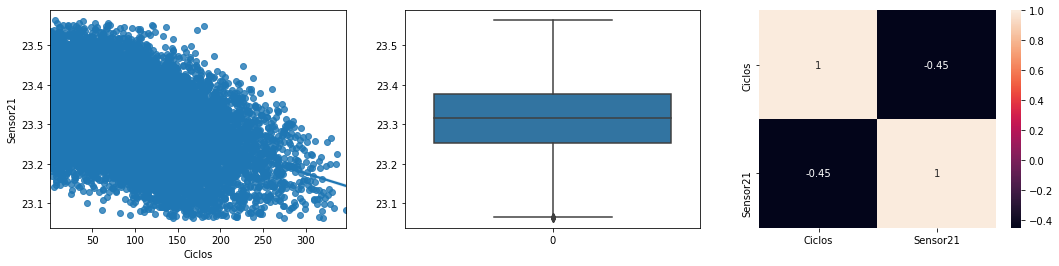

In [36]:
grafico_de_correlacao('Ciclos','Sensor21',df4)

## 4.3 Multivariate Analysis

###4.3.1. Numerical Atributes

Text(0.5, 1.0, 'Correlação entre features numéricas')

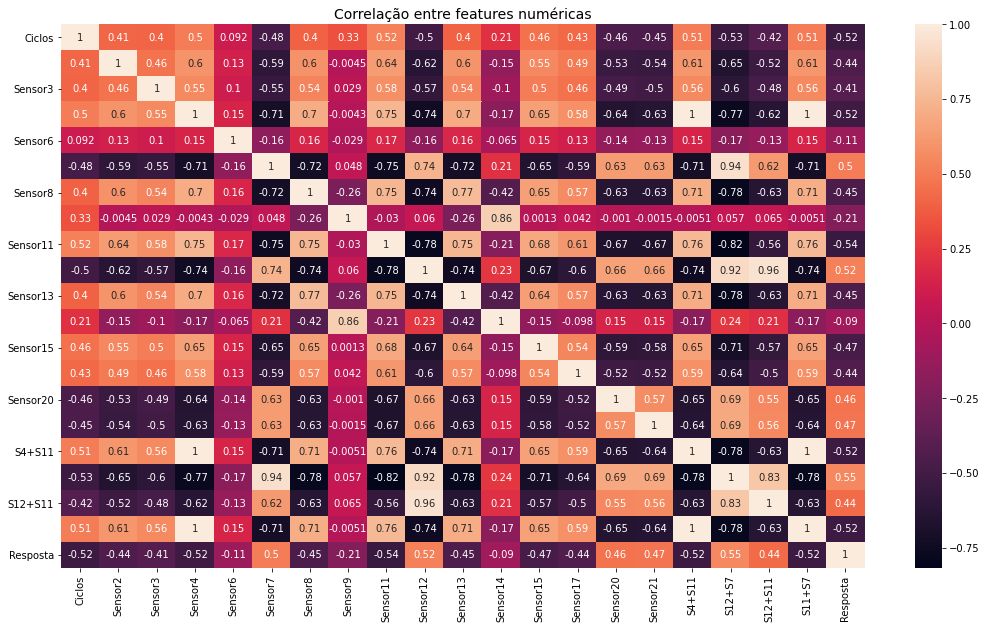

In [37]:
lista=['CiclosAteFalhar','MotorId','UltimoCiclo','Config2','Config1']
aux=df4.drop(lista,axis=1)

#grafico de correlacao
correlation=aux.corr(method='pearson')
ax=sns.heatmap(correlation,annot=True);
ax.figure.set_size_inches(18,10)
ax.set_title('Correlação entre features numéricas',fontsize=14)

#5.0. PASSO 5 - DATA PREPARATION

In [38]:
#copia do dataframe
df5=df4.copy()

##5.1. Rescaling

In [39]:
selecao=df5.drop(['MotorId','Resposta'],axis=1)

df5=rescaling(df5,selecao)

## 5.2. Transformation

###5.2.1. Encoding

In [40]:
le=LabelEncoder()
df5['MotorId']=le.fit_transform(df5['MotorId'])

###5.2.2. Response Variable transformation


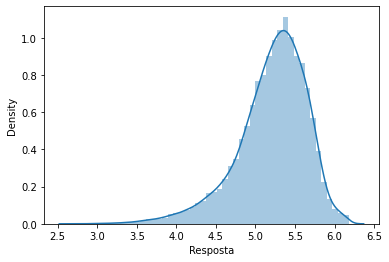

In [41]:
df5['Resposta']=np.log1p(df5['Resposta'])

sns.distplot(df5['Resposta'])

#6.0. PASSO 6 - FEATURE SELECTION

In [42]:
#copia do dataframe
df6=df5.copy()

##6.1. Split dataframe into training and test dataset.

In [43]:
#train
aux=df6[(df6['MotorId']>20) & (df6['MotorId']<90)]

x_train=aux.drop(['Resposta'],axis=1)
y_train=aux['Resposta']

#test
aux1=df6[(df6['MotorId']<=20)] 
aux2=df6[(df6['MotorId']>=90)]
aux3=pd.concat([aux1,aux2],axis=0)

x_test=aux3.drop(['Resposta'],axis=1) 
y_test=aux3['Resposta']

##6.2. Boruta as feature selector


In [44]:
'''boruta=boruta(x_train,y_train)'''

'boruta=boruta(x_train,y_train)'

##6.2.1. Best Features from Boruta

In [45]:
'''best_features(boruta,x_train)'''

'best_features(boruta,x_train)'

##6.3. Manual Feature selection


In [46]:
cols_selected_boruta=['MotorId', 'Ciclos', 'Sensor2', 'Sensor3',
                      'Sensor4', 'Sensor7', 'Sensor8', 'Sensor9', 'Sensor11',
                      'Sensor12', 'Sensor13', 'Sensor14', 'Sensor15',
                      'Sensor20', 'Sensor21', 'UltimoCiclo', 'CiclosAteFalhar',
                       'S4+S11', 'S12+S7', 'S11+S7']

#Columns to add
feat_to_add=['Resposta']
cols_selected_boruta_full=cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add) 

#7.0. PASSO 7 - MACHINE LEARNING MODELLING

In [47]:
#train
x_train=x_train[cols_selected_boruta]

#test
x_test=x_test[cols_selected_boruta]

#x_training
x_training=df6[cols_selected_boruta_full]

#df7
df7=x_training.copy()

##7.1. Average Model

In [48]:
#data
aux=pd.concat([x_test,y_test],axis=1)

#medias_por_intervalos
medias_por_intervalos=[]
for i in range(1,9):
  inicio=2+(i*0.5)
  fim=2.5+(i*0.5)
  medias_por_intervalos.append(aux[(aux['Resposta']>=inicio) & (aux['Resposta']<fim)]['Resposta'].mean())

#lista_de_dataframes
lista_de_dataframes=[]
for i in range(1,9):
  inicio=2+(i*0.5)
  fim=2.5+(i*0.5)
  selecao=aux[(aux['Resposta']>=inicio) & (aux['Resposta']<fim)]

  #prediction
  selecao['Predicoes']=medias_por_intervalos[i-1]
  lista_de_dataframes.append(selecao)

#concat
aux=pd.concat([lista_de_dataframes[0],lista_de_dataframes[1],lista_de_dataframes[2],
           lista_de_dataframes[3],lista_de_dataframes[4],lista_de_dataframes[5],
           lista_de_dataframes[6],lista_de_dataframes[7]],axis=0)

#performance
baseline_results=ml_error('Averege Model',np.expm1(aux['Resposta']),np.expm1(aux['Predicoes']))
baseline_results

,Model Name,MAE,MAPE,RMSE,ACCURACY
0,Averege Model,-0.009029,0.113282,28.853519,85.0


##7.2. Linear Regression Mode

In [49]:
#model
lr=LinearRegression()
lr_train=lr.fit(x_train,y_train)

#prediction
yhat_lr=lr_train.predict(x_test)

#performance
lr_results=ml_error('Linear Regressor',np.expm1(y_test),np.expm1(yhat_lr))
lr_results

,Model Name,MAE,MAPE,RMSE,ACCURACY
0,Linear Regressor,0.008873,0.085371,37.523865,74.0


###7.2.1. Linear Regression Model- Cross Validation

In [50]:
lr_results_cv=cross_validation(x_training,4,'Linear Regression',lr,verbose=False)
lr_results_cv

,Model name,MAE CV,MAPE CV,RMSE CV,ACURACY CV
0,Linear Regression,-0.02 +/- 0.01,0.1 +/- 0.01,28.82 +/- 13.02,85.5 +/- 9.81


##7.3. Linear Regression Regularized Model-Lasso

In [51]:
#model
lrr=Lasso(alpha=0.01)
lrr_train=lrr.fit(x_train,y_train)

#prediction
yhat_lrr=lrr_train.predict(x_test)

#performance
lrr_results=ml_error('Linear Regressor-Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_results

,Model Name,MAE,MAPE,RMSE,ACCURACY
0,Linear Regressor-Lasso,0.032655,0.091691,23.051747,90.0


###7.3.1. Linear Regression Regularized Model-Lasso-  Cross Validation

In [52]:
lrr_results_cv=cross_validation(x_training,4,'Lasso',lrr,verbose=False)
lrr_results_cv

,Model name,MAE CV,MAPE CV,RMSE CV,ACURACY CV
0,Lasso,-0.04 +/- 0.04,0.13 +/- 0.02,21.26 +/- 1.9,92.25 +/- 0.83


##7.4. Random Forest Regressor


In [53]:
#model
rf=RandomForestRegressor(n_estimators=10,n_jobs=-1,random_state=42).fit(x_train,y_train)
rf_train=rf.fit(x_train,y_train)

#prediction
yhat_rf=rf_train.predict(x_test)

#performance
rf_results=ml_error('Random Forest',np.expm1(y_test),np.expm1(yhat_rf))
rf_results

,Model Name,MAE,MAPE,RMSE,ACCURACY
0,Random Forest,-0.00668,0.027461,8.933947,99.0


###7.4.1. Random Forest Regressor-Cross validation

In [54]:
rf_results_cv=cross_validation(x_training,4,'Rendom Forest Regressor',rf,verbose=True)
rf_results_cv

,Model name,MAE CV,MAPE CV,RMSE CV,ACURACY CV
0,Rendom Forest Regressor,-0.01 +/- 0.01,0.03 +/- 0.01,8.73 +/- 5.14,98.5 +/- 1.5


##7.5. XGBoost Regressor

In [55]:
#model
model_xgb=xgb.XGBRegressor(objective='reg:squarederror',
                           eta=0.01,max_depth=10,
                           subsample=0.7,
                           colsample_bytree=0.9).fit(x_train,y_train)
model_xgb_train=model_xgb.fit(x_train,y_train)

#prediction
yhat_xgb=model_xgb_train.predict(x_test)

#performance
xgb_results=ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb))
xgb_results

,Model Name,MAE,MAPE,RMSE,ACCURACY
0,XGBoost Regressor,-0.005979,0.043595,15.494409,96.0


###7.5.1. XGBoost Regressor-Cross validation

In [56]:
xgb_results_cv=cross_validation(x_training,4,'XGBoost Regressor',model_xgb,verbose=True)
xgb_results_cv

,Model name,MAE CV,MAPE CV,RMSE CV,ACURACY CV
0,XGBoost Regressor,-0.0 +/- 0.01,0.05 +/- 0.02,14.72 +/- 10.18,95.5 +/- 4.92


##7.6. Compare Model's Performance

###7.6.1. Single Performance


In [57]:
modelling_results=pd.concat([baseline_results,lr_results,lrr_results,rf_results,xgb_results])
modelling_results.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE,ACCURACY
0,Random Forest,-0.006680,0.027461,8.933947,99.0
0,XGBoost Regressor,-0.005979,0.043595,15.494409,96.0
0,Linear Regressor-Lasso,0.032655,0.091691,23.051747,90.0
0,Averege Model,-0.009029,0.113282,28.853519,85.0
0,Linear Regressor,0.008873,0.085371,37.523865,74.0


###7.6.2. Real Performance - Cross Validation


In [58]:
modelling_results_cv=pd.concat([lr_results_cv,lrr_results_cv,rf_results_cv,xgb_results_cv])
modelling_results_cv.sort_values('RMSE CV')

,Model name,MAE CV,MAPE CV,RMSE CV,ACURACY CV
0,XGBoost Regressor,-0.0 +/- 0.01,0.05 +/- 0.02,14.72 +/- 10.18,95.5 +/- 4.92
0,Lasso,-0.04 +/- 0.04,0.13 +/- 0.02,21.26 +/- 1.9,92.25 +/- 0.83
0,Linear Regression,-0.02 +/- 0.01,0.1 +/- 0.01,28.82 +/- 13.02,85.5 +/- 9.81
0,Rendom Forest Regressor,-0.01 +/- 0.01,0.03 +/- 0.01,8.73 +/- 5.14,98.5 +/- 1.5


#8.0. PASSO 8 - HYPERPARAMETER FINE TUNING

In [59]:
#copia do dataframe
df8=df7.copy()

##8.1.Random Search

In [60]:
'''param={ 'n_estimators':      [1500,1700,2500,3000,3500],
        'eta':               [0.01,0.03],
        'max_depth':         [3,5,9],
        'subsample':         [0.1,0.5,0.7],
        'colsample_bytree':  [0.3,0.7,0.9],
        'min_child_weight':  [3,8,15]
}
MAX_EVAL=20


final_results=pd.DataFrame()

for i in range (MAX_EVAL):

  #Choose values for parameters randomly
  hp={k:random.sample(v,1)[0] for k,v in param.items()}
  print(hp)

  #model
  model_xgb=xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=hp['n_estimators'],
                            eta=hp['eta'],
                            max_depth=hp['max_depth'],
                            subsample=hp['subsample'],
                            colsample_bytree=hp['colsample_bytree'],
                            min_child_weight=hp['min_child_weight'])
  
  #performance
  results=cross_validation(x_training,4,'XGBoost Regressor',model_xgb,verbose=False) 
  final_results=pd.concat([final_results,results])
  
final_results'''

"param={ 'n_estimators':      [1500,1700,2500,3000,3500],\n        'eta':               [0.01,0.03],\n        'max_depth':         [3,5,9],\n        'subsample':         [0.1,0.5,0.7],\n        'colsample_bytree':  [0.3,0.7,0.9],\n        'min_child_weight':  [3,8,15]\n}\nMAX_EVAL=20\n\n\nfinal_results=pd.DataFrame()\n\nfor i in range (MAX_EVAL):\n\n  #Choose values for parameters randomly\n  hp={k:random.sample(v,1)[0] for k,v in param.items()}\n  print(hp)\n\n  #model\n  model_xgb=xgb.XGBRegressor(objective='reg:squarederror',\n                            n_estimators=hp['n_estimators'],\n                            eta=hp['eta'],\n                            max_depth=hp['max_depth'],\n                            subsample=hp['subsample'],\n                            colsample_bytree=hp['colsample_bytree'],\n                            min_child_weight=hp['min_child_weight'])\n  \n  #performance\n  results=cross_validation(x_training,4,'XGBoost Regressor',model_xgb,verbose=False) \

##8.2.Final Model

In [61]:
param_tuned={'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3,
             'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}

#model
model_xgb_tuned=xgb.XGBRegressor(     objective=           'reg:squarederror',
                                      n_estimators=        param_tuned['n_estimators'],
                                      eta=                 param_tuned['eta'],
                                      max_depth=           param_tuned['max_depth'],
                                      subsample=           param_tuned['subsample'],
                                      colsample_bytree=    param_tuned['colsample_bytree'],
                                      min_child_weight=    param_tuned['min_child_weight'])

model_xgb_tuned_train=model_xgb_tuned.fit(x_train,y_train)

#prediction
yhat_xgb_tuned=model_xgb_tuned_train.predict(x_test) 

#performance
xgb_results_cv=cross_validation(x_training,4,'XGBoost Regressor',model_xgb_tuned,verbose=True)
xgb_results_cv

,Model name,MAE CV,MAPE CV,RMSE CV,ACURACY CV
0,XGBoost Regressor,-0.01 +/- 0.01,0.05 +/- 0.02,15.4 +/- 10.71,95.0 +/- 5.34


In [62]:
#Save trained model
pickle.dump(model_xgb_tuned_train,open('/content/motor_predict.pkl','wb'))

#9.0. PASSO 9 - TRANSLATION AND INTERPRETATION OF THE ERROR

In [63]:
#copia do dataframe
df9=df8.copy()

##9.1.Machine Learning Performance

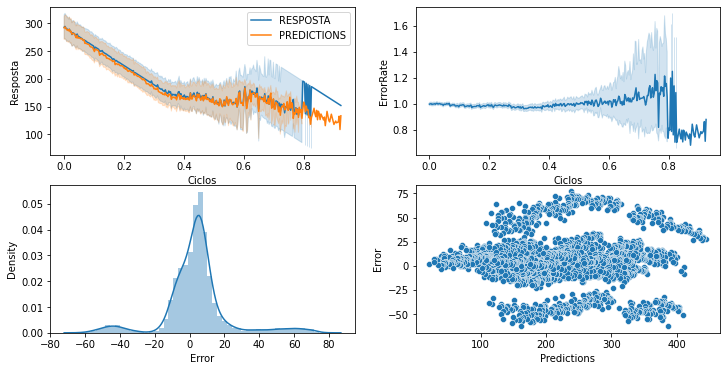

In [64]:
df9=pd.concat([x_test,y_test],axis=1)

#rescale
df9['Resposta']=np.expm1(df9['Resposta'])
df9['Predictions']=np.expm1(yhat_xgb_tuned)

df9['Error']=df9['Resposta']-df9['Predictions']
df9['ErrorRate']=df9['Predictions']/df9['Resposta']

plt.subplot(2,2,1)
ax=sns.lineplot(x='Ciclos',y='Resposta',data=df9,label='RESPOSTA')
ax=sns.lineplot(x='Ciclos',y='Predictions',data=df9,label='PREDICTIONS')
ax.figure.set_size_inches(12,6)

plt.subplot(2,2,2)
ax=sns.lineplot(x='Ciclos',y='ErrorRate',data=df9)

plt.subplot(2,2,3)
ax=sns.distplot(df9['Error'])

plt.subplot(2,2,4)
ax=sns.scatterplot(df9['Predictions'],df9['Error'])

#10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

##Loading data

In [65]:
#loading
df10=test_raw.copy()

##Feature engeneering

In [66]:
#ultimo_ciclo
ultimo_ciclo=[]
for i in range(1,101):
  ultimo_ciclo.append(df10[df10['MotorId']==i]['Ciclos'].max())

ultimo_ciclo=pd.DataFrame(data=ultimo_ciclo,columns=['UltimoCiclo'])

#merge rul_raw,ultimo_ciclo e motor_id
aux=pd.merge(rul_raw,ultimo_ciclo,left_index=True,right_index=True)

motor_id=[]
for i in range(1,101):
  motor_id.append(i)
motor_id=pd.DataFrame(data=motor_id,columns=['MotorId'])

aux=pd.merge(aux,motor_id,left_index=True,right_index=True)
df10=pd.merge(df10,aux,on='MotorId')

#CiclosAteFalhar
df10['CiclosAteFalhar']=df10['UltimoCiclo']+df10['RulEsperado']

#S4+S11
df10['S4+S11']=(df10['Sensor4']+df10['Sensor11'])/2

#S12+S7
df10['S12+S7']=(df10['Sensor12']+df10['Sensor7'])/2

#S11+S7
df10['S11+S7']=(df10['Sensor4']+df10['Sensor11'])/2

#selecao de features
features_importantes=['MotorId', 'Ciclos', 'Sensor2', 'Sensor3','Sensor4',
                      'Sensor7', 'Sensor8', 'Sensor9', 'Sensor11','Sensor12',
                      'Sensor13', 'Sensor14', 'Sensor15','Sensor20', 'Sensor21',
                      'UltimoCiclo', 'CiclosAteFalhar','S4+S11', 'S12+S7', 'S11+S7']

df10=df10[features_importantes]

##Data preparation

In [67]:
#rescaling
selecao=df10.drop(['MotorId'],axis=1)
df10=rescaling(df10,selecao)

#enconding
le=LabelEncoder()
df10['MotorId']=le.fit_transform(df10['MotorId'])

##Predictions

In [68]:
#prediction
predicoes_finais=pd.DataFrame(data=np.expm1(model_xgb_tuned_train.predict(df10)),columns=['Predictions(RUL)'])
predicoes_finais=pd.concat([df10,predicoes_finais],axis=1)

#Filtro para predicoes
lista=[]
for i in range(0,98):
  motor=predicoes_finais[predicoes_finais['MotorId']==i]
  index=motor['Ciclos'].index.max()
  lista.append(index)
predicoes_finais=predicoes_finais.iloc[lista]
predicoes_finais=predicoes_finais[['MotorId','Predictions(RUL)']].reset_index()

#Predictions(RUL),WorstScenario,BestScenario
predicoes_finais['Predictions(RUL)']=   predicoes_finais['Predictions(RUL)'].astype(int)
predicoes_finais['WorstScenario']=      (predicoes_finais['Predictions(RUL)']*(1-0.0534)).astype(int)
predicoes_finais['BestScenario']=       (predicoes_finais['Predictions(RUL)']*(1+0.0534)).astype(int)
predicoes_finais=                       predicoes_finais[['MotorId','Predictions(RUL)','WorstScenario','BestScenario']]
predicoes_finais

,MotorId,Predictions(RUL),WorstScenario,BestScenario
0,0,131,124,137
1,1,114,107,120
2,2,109,103,114
3,3,111,105,116
4,4,119,112,125
...,...,...,...,...
93,93,86,81,90
94,94,186,176,195
95,95,212,200,223
96,96,141,133,148


In [70]:
#Save predicoes
pickle.dump(predicoes_finais,open('/content/predicoes_finais.pkl','wb'))